## Imports

In [1]:
from typing import Union
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Pairwise slerp

In [2]:
def slerp(
    t: Union[float, torch.Tensor],
    v0: torch.Tensor,
    v1: torch.Tensor,
    DOT_THRESHOLD: float = 0.9995,
    eps: float = 1e-8,
):
    """
    Spherical linear interpolation using PyTorch

    Args:
        t (float/torch.Tensor): Float value between 0.0 and 1.0
        v0 (torch.Tensor): Starting vector
        v1 (torch.Tensor): Final vector
        DOT_THRESHOLD (float): Threshold for considering the two vectors as
                               colinear. Not recommended to alter this.
    Returns:
        v2 (torch.Tensor): Interpolation vector between v0 and v1
    """
    # Ensure inputs are tensors
    v0 = torch.tensor(v0, dtype=torch.float32).cuda()
    v1 = torch.tensor(v1, dtype=torch.float32).cuda()

    v0_copy = v0.clone()
    v1_copy = v1.clone()

    # Normalize the vectors to get the directions and angles
    v0 = v0 / (torch.norm(v0) + eps)
    v1 = v1 / (torch.norm(v1) + eps)

    # Dot product with the normalized vectors
    dot = torch.sum(v0 * v1)

    # If absolute value of dot product is almost 1, vectors are ~colinear, so use lerp
    if torch.abs(dot) > DOT_THRESHOLD:
        print("colinear vectors")
        return None 

    # Calculate initial angle between v0 and v1
    theta_0 = torch.acos(dot)
    sin_theta_0 = torch.sin(theta_0)

    # Angle at timestep t
    theta_t = theta_0 * t
    sin_theta_t = torch.sin(theta_t)

    # Finish the slerp algorithm
    s0 = torch.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    res = s0 * v0_copy + s1 * v1_copy

    return res

## Generalized slerp

In [3]:
def inner_product(point, tangent_vector_a, tangent_vector_b):
    return torch.tensordot(
        tangent_vector_a, tangent_vector_b, dims=tangent_vector_a.ndim
    )

def dist(point_a, point_b):
    inner = max(min(inner_product(point_a, point_a, point_b), 1), -1)
    return torch.arccos(inner)

def norm(point, tangent_vector):
    return torch.norm(tangent_vector)

def projection(point, vector):
    return vector - inner_product(point, point, vector) * point

def ell_q(q, p):
    vector = projection(q, p - q)
    distance = dist(q, p)
    epsilon = np.finfo(np.float64).eps
    factor = (distance + epsilon) / (norm(q, vector) + epsilon)
    return factor * vector



def exp_q(point, tangent_vector):
    norm_value = norm(point, tangent_vector)
    return point * torch.cos(norm_value) + tangent_vector * torch.sinc(norm_value / np.pi)


In [4]:
d = 2 # Dimension of the sphere
q = torch.tensor([0.0, 0.0, 1.0])  # A (d+1)-dimensional point 
p = torch.tensor([0.0, 1.0, 2.0])  # Another(d+1)-dimensional point 

q = q / torch.norm(q)
p = p / torch.norm(p)

tangent_vector = ell_q(q, p)
print("Logarithm map (tangent vector):", tangent_vector)

point_on_sphere = exp_q(q, tangent_vector)
print("Exponential map (point on sphere):", point_on_sphere)

Logarithm map (tangent vector): tensor([0.0000, 0.4636, 0.0000])
Exponential map (point on sphere): tensor([0.0000, 0.4472, 0.8944])


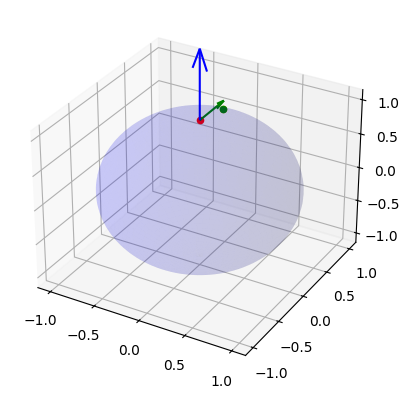

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)

# Plot the points
ax.scatter(q[0], q[1], q[2], color='r')
ax.scatter(p[0], p[1], p[2], color='g')

ax.scatter(point_on_sphere[0], point_on_sphere[1], point_on_sphere[2], color='y')
# Plot the tangent vector

ax.quiver(q[0], q[1], q[2], tangent_vector[0], tangent_vector[1], 0, color='g')

# rotate the plot in 3D to ensure the tangent vector is correct

# plot the normal of q 

# Plot the normal vector at q
ax.quiver(q[0], q[1], q[2], q[0], q[1], q[2], color='b', label='Normal vector')

plt.show()


In [6]:
def spherical_weighted_average(points, weights, tol=1e-8, max_iter=1000, dim=2):
    """
    Compute the spherical weighted average of points on a sphere with given weights using PyTorch.
    
    Args:
    - points (torch.Tensor): A tensor of shape (n, d+1) representing n points on the d-dimensional sphere S^d.
    - weights (torch.Tensor): A tensor of shape (n,) representing the non-negative weights with sum 1.
    - tol (float): Tolerance for the stopping criterion based on the norm of u.
    - max_iter (int): Maximum number of iterations for the main loop.

    Returns:
    - q (torch.Tensor): The spherical weighted average of the input points.
    """

    print(f'Points shape: {points.shape}')
    print(f'Weights shape: {weights.shape}')

    # (num_points, d+1)
    assert points.shape[-1] == dim+1, f"points.shape = {points.shape}, dim = {dim}"

    # points have shape (num_tasks, num_params)
    # weights have shape (num_tasks,)
    
    with torch.no_grad():
        # Ensure weights sum to 1
        weights = weights / weights.sum()

        # Initialization
        # q has shape (d+1,)
        q = (weights[:, None] * points).sum(dim=0)
        q = q / (torch.norm(q) )

        assert q.shape[0] == dim+1, f"q.shape = {q.shape}, dim = {dim}"

        for _ in tqdm(range(max_iter)):
            # Compute p_i^* for each point

            # (num_points, d+1)
            p_i_stars = torch.stack([ell_q(q, p) for p in points])
            u = (weights[:, None] * (p_i_stars - q)).sum(dim=0) 
            q = exp_q(q, q + u)

            # Check if u is sufficiently small
            if torch.norm(u) < tol:
                break
            
            print(torch.norm(u))
    
    return q

In [7]:
p, q = torch.tensor([15, 7, 6.5]), torch.tensor([25, -15, 13.0])
p, q = p / torch.norm(p), q / torch.norm(q)

In [8]:
weighted_avg = spherical_weighted_average(torch.stack([p, q]), torch.tensor([0.5, 0.5]), dim=2, max_iter=500)

Points shape: torch.Size([2, 3])
Weights shape: torch.Size([2])


100%|██████████| 500/500 [00:00<00:00, 4404.26it/s]

tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0

In [9]:
import copy


slerped_point = slerp(0.5, copy.deepcopy(p), copy.deepcopy(q)).cpu()

/tmp/ipykernel_3755851/1939217469.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v0 = torch.tensor(v0, dtype=torch.float32).cuda()
/tmp/ipykernel_3755851/1939217469.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v1 = torch.tensor(v1, dtype=torch.float32).cuda()


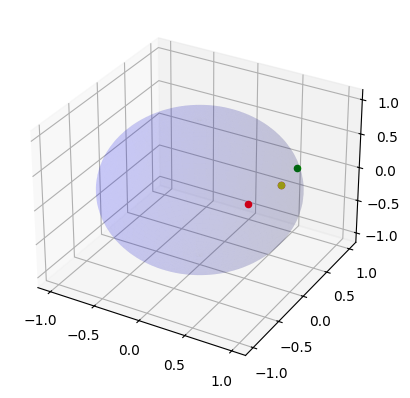

In [10]:
# plot everything 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)

# Plot the points
ax.scatter(q[0], q[1], q[2], color='r')
ax.scatter(p[0], p[1], p[2], color='g')

ax.scatter(weighted_avg[0], weighted_avg[1], weighted_avg[2], color='y')
ax.scatter(slerped_point[0], slerped_point[1], slerped_point[2], color='m')

In [11]:
(torch.tensor(slerped_point) - weighted_avg).norm()

/tmp/ipykernel_3755851/2691730747.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.tensor(slerped_point) - weighted_avg).norm()


tensor(1.1921e-07)

In [12]:
print(slerped_point)
print(weighted_avg)

tensor([ 0.9024, -0.0423,  0.4287])
tensor([ 0.9024, -0.0423,  0.4287])


In [13]:
(weighted_avg - slerped_point.cpu()).norm()

tensor(1.1921e-07)